# G.SubtVision - Etapa 2

In [10]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.metrics import classification_report, precision_recall_fscore_support, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import ast
import os
from collections import defaultdict

### 2.1 - Unificaod as tabelas - tabela com os 30 folds da MobileNet, GoogleNet e ShuffleNet

In [2]:
# Função para carregar e renomear as colunas
def load_and_rename(file_path, model_name, fold):
    # Carregar o arquivo CSV
    df = pd.read_csv(file_path)

    # Definir o sufixo com base no modelo e no fold
    suffix = f'_{model_name}{fold}'

    # Renomear as colunas de predição
    df.rename(columns={
        'predicted_label': f'predicted_label{suffix}',
        'predicted_probability': f'predicted_probability{suffix}',
        'probability_vector': f'probability_vector{suffix}',
        'probability_std_dev': f'probability_std_dev{suffix}'
    }, inplace=True)

    return df

In [5]:
# Caminho das pastas
folders = ['m', 's', 'g']  # Substitua pelos caminhos reais
model_names = ['0707-213643_MobileNetV2', '0711-213955_ShuffleNetV2', '0710-161214_GoogleNet']
BASE_PATH = r'inputs/summary_results/'
# Etapa para carregar os arquivos e renomear as colunas
all_data = []
classes = ['cin', 'ebv', 'gs', 'msi']

for model_name, folder in zip(model_names, folders):
    for fold in range(10):  # Para cada fold de 0 a 9
        # Caminho do arquivo (modifique o caminho conforme sua estrutura de pastas)
        file_path = f'{BASE_PATH}/{model_name}_fold{fold}_results.csv'  # Ajuste o caminho real
        if os.path.exists(file_path):
            # Carregar e renomear as colunas
            df_renamed = load_and_rename(file_path, folder, fold)
            all_data.append(df_renamed)
        else:
            print(f'Arquivo não encontrado: {file_path}')

# Exibir um exemplo dos dados renomeados
print(f"Nomes das colunas da primeira tabela mesclada: \n {list(all_data[0].columns)}")

# ETAPA 2

# Mesclar os arquivos pela chave 'image_path' e 'true_label'
merged_df = all_data[0]
for df in all_data[1:]:
    merged_df = merged_df.merge(df, on=['image_path', 'true_label', 'true_label_one_hot'], how='outer')

# ETAPA 3

# Salvando tabela mesclada
merged_df.to_csv('outputs/merged_table_mob_shu_gg.csv', index=False)
print(f'Tabela mesclada salva! Com dimensões: {merged_df.shape}')

Nomes das colunas da primeira tabela mesclada: 
 ['image_path', 'true_label', 'true_label_one_hot', 'predicted_label_m0', 'predicted_probability_m0', 'probability_vector_m0', 'probability_std_dev_m0']
Tabela mesclada salva! Com dimensões: (179952, 123)


## 2.2 - Gerando os resultados

In [6]:
# Passo 1: Hard Voting
def hard_voting(df, print_flag=True):
    # Extrair as colunas de predicted_label
    cols_hard = [f'predicted_label_m{i}' for i in range(10)] + [f'predicted_label_s{i}' for i in range(10)] + [f'predicted_label_g{i}' for i in range(10)]
    
    # Função para fazer a votação majoritária
    def get_majority_vote(row):
        votes = [row[col] for col in cols_hard]
        return max(set(votes), key=votes.count)
    
    # Aplicar a função para calcular a predição do Hard Voting
    df['hard_voting_label'] = df.apply(get_majority_vote, axis=1)
    
    if(print_flag):
        # Calcular as métricas (classificação)
        print("===== HARD VOTING MÉTRICAS =====")
        print(classification_report(df['true_label'], df['hard_voting_label']))
    
    return df

# Passo 2: Soft Voting
# Função para calcular a classe com maior probabilidade (Soft Voting) usando probability_vector
def soft_voting(df, print_flag=True):
    # Extrair as colunas de probability_vector
    cols_soft = [f'probability_vector_m{i}' for i in range(10)] + [f'probability_vector_s{i}' for i in range(10)] + [f'probability_vector_g{i}' for i in range(10)]
    
    # Função para converter dicionário para vetor de probabilidades
    def dict_to_prob_vector(prob_dict):
        # Transformar o dicionário de probabilidades para vetor ordenado
        classes = ['cin', 'ebv', 'gs', 'msi']
        return [prob_dict.get(cls, 0) for cls in classes]
    
    # Função para calcular a média das probabilidades
    def get_soft_vote(row):
        prob_vectors = [dict_to_prob_vector(ast.literal_eval(row[col])) for col in cols_soft]
        prob_vectors = np.array(prob_vectors)  # Converter para um array numpy
        avg_probs = prob_vectors.mean(axis=0)  # Média das probabilidades para cada classe
        return avg_probs
    
    # Aplicar a função para calcular a probabilidade média
    df['soft_voting_probs'] = df.apply(get_soft_vote, axis=1)
    
    # Escolher a classe com maior probabilidade média
    classes = ['cin', 'ebv', 'gs', 'msi']
    df['soft_voting_label'] = df['soft_voting_probs'].apply(lambda x: classes[np.argmax(x)])
    
    if(print_flag):
        # Calcular as métricas (classificação)
        print("\n===== SOFT VOTING MÉTRICAS =====")
        print(classification_report(df['true_label'], df['soft_voting_label']))
    
    return df
    

# Função para extrair o vetor de probabilidade de um dicionário
def dict_to_prob_vector(prob_dict):
    classes = ['cin', 'ebv', 'gs', 'msi']
    return [prob_dict.get(cls, 0) for cls in classes]

# Função para calcular a média das probabilidades de todos os modelos e folds
def get_soft_voting_probs(row, model_prefixes, folds):
    prob_vectors = []
    
    # Iterar sobre os modelos e folds
    for model in model_prefixes:
        for fold in range(folds):
            # Construir o nome da coluna de probabilidade
            col_name = f'probability_vector_{model}{fold}'
            if col_name in row:
                prob_dict = ast.literal_eval(row[col_name])  # Extrair o dicionário
                prob_vector = dict_to_prob_vector(prob_dict)  # Converter para vetor de probabilidade
                prob_vectors.append(prob_vector)
    
    # Calcular a média das probabilidades para cada classe
    prob_vectors = np.array(prob_vectors)
    avg_probs = prob_vectors.mean(axis=0)
    
    return avg_probs

# Função para obter o rótulo de Soft Voting
def get_soft_voting_label(row, model_prefixes, folds):
    avg_probs = get_soft_voting_probs(row, model_prefixes, folds)
    classes = ['cin', 'ebv', 'gs', 'msi']
    return classes[np.argmax(avg_probs)]  # Classe com maior probabilidade média

In [7]:
# Carregar seu DataFrame
df = merged_df

# Calcular as métricas para Hard Voting
df = hard_voting(df)
# Calcular as métricas para Soft Voting
df = soft_voting(df)

===== HARD VOTING MÉTRICAS =====
              precision    recall  f1-score   support

         cin       0.63      0.79      0.70     89707
         ebv       0.58      0.41      0.48     25081
          gs       0.33      0.40      0.36     27191
         msi       0.64      0.27      0.38     37973

    accuracy                           0.57    179952
   macro avg       0.55      0.47      0.48    179952
weighted avg       0.58      0.57      0.55    179952


===== SOFT VOTING MÉTRICAS =====
              precision    recall  f1-score   support

         cin       0.62      0.80      0.70     89707
         ebv       0.62      0.39      0.48     25081
          gs       0.34      0.40      0.36     27191
         msi       0.65      0.28      0.39     37973

    accuracy                           0.57    179952
   macro avg       0.56      0.47      0.48    179952
weighted avg       0.59      0.57      0.56    179952



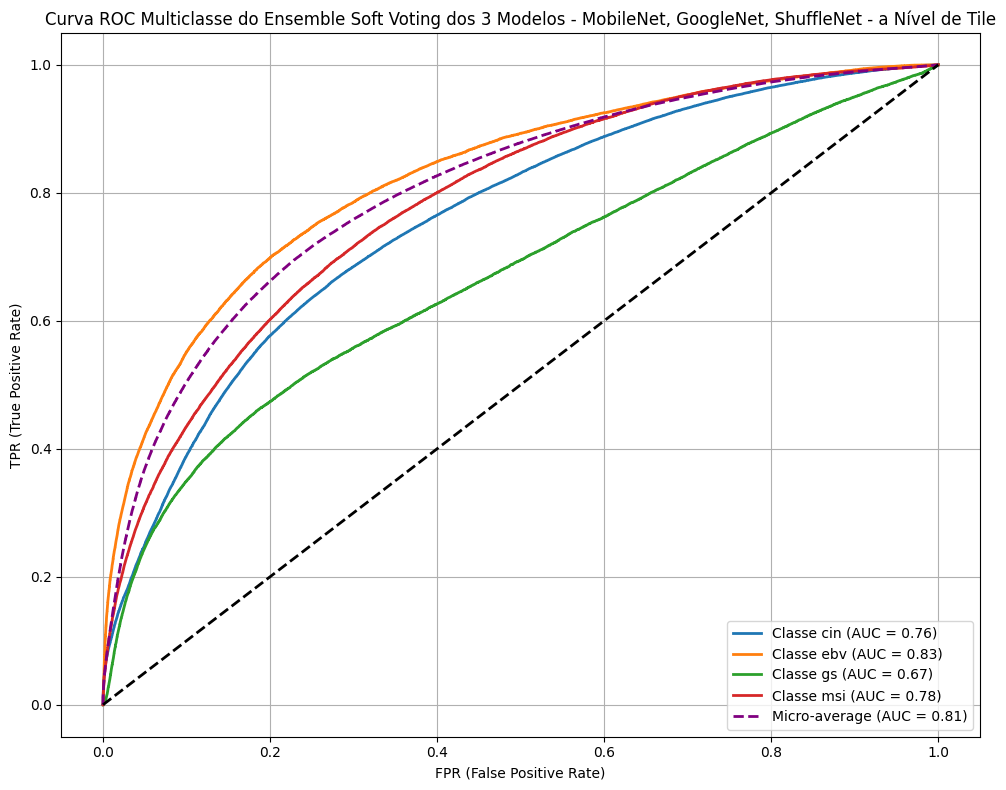

In [8]:
# Definir os prefixos dos modelos e número de folds
model_prefixes = ['m', 's', 'g']  # MobileNetV2 (m), ShuffleNet (s), GoogleNet (g)
folds = 10  # De fold0 a fold9

# Aplicar Soft Voting e calcular as predições e probabilidades médias
df['soft_voting_probs'] = df.apply(get_soft_voting_probs, axis=1, model_prefixes=model_prefixes, folds=folds)
df['soft_voting_label'] = df.apply(get_soft_voting_label, axis=1, model_prefixes=model_prefixes, folds=folds)

# Binarizar os rótulos verdadeiros (true_label) para o cálculo da curva ROC
classes = ['cin', 'ebv', 'gs', 'msi']
y_true = label_binarize(df['true_label'], classes=classes)

# Soft Voting: Convertendo as probabilidades para matriz
y_pred_soft = np.array(list(df['soft_voting_probs']))

# Preparando o gráfico
plt.figure(figsize=(10, 8))

# Loop sobre cada classe para gerar a curva ROC
roc_auc = {}
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_soft[:, i])
    roc_auc[cls] = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Classe {cls} (AUC = {roc_auc[cls]:.2f})')

# Calcular o micro-average ROC
fpr_micro, tpr_micro, _ = roc_curve(y_true.ravel(), y_pred_soft.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plotar a curva ROC para o micro-average
plt.plot(fpr_micro, tpr_micro, color='purple', linestyle='--', lw=2, label=f'Micro-average (AUC = {roc_auc_micro:.2f})')

# Plotar linha de aleatoriedade
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Definir títulos e rótulos
plt.xlabel('FPR (False Positive Rate)')
plt.ylabel('TPR (True Positive Rate)')
plt.title('Curva ROC Multiclasse do Ensemble Soft Voting dos 3 Modelos - MobileNet, GoogleNet, ShuffleNet - a Nível de Tile')
plt.legend(loc='lower right')
plt.grid(True)

# Exibir o gráfico
plt.tight_layout()
plt.show()

In [9]:
df.to_csv("outputs/merged_table_30folds_mob_gg_sh_hard_soft_ensemble.csv", index=False)

## 2.3 - Gerando métricas para nível de IMAGEM/PATIENT

In [26]:
def aggregate_to_level(df, classes, level):
    # extrair image_id do image_path
    if level == 'image':
        df[f'image_id'] = df[f'image_path'].apply(lambda x: x.split('/')[-3].split('_files')[0])
    elif level == 'patient':
        df[f'patient_id'] = df[f'image_path'].apply(lambda x: x.split('/')[-3].split('_files')[0][:12])
        
    # função auxiliar para calcular o hard_voting_label por imagem
    def majority_vote(labels):
        return labels.value_counts().idxmax()
    
    def convert_to_array(probs):
        if isinstance(probs, str):
            # Remover colchetes e converter para array
            try:
                probs = probs.strip('[]')
                return np.array([float(x) for x in probs.split()])
            except:
                return np.array([0.0, 0.0, 0.0, 0.0])
        elif isinstance(probs, (list, np.ndarray)):
            return np.array(probs)
        else:
            return np.array([0.0, 0.0, 0.0, 0.0])
    
    # média dos vetores por imagem
    def mean_vec(series: pd.Series):
        return np.mean(np.vstack(series.values), axis=0)
    
    df['soft_voting_probs'] = df['soft_voting_probs'].apply(convert_to_array)

    # agregação por image_id
    agg_df = df.groupby(f'{level}_id').agg({
        'hard_voting_label': majority_vote,
        'soft_voting_probs': mean_vec,
        'true_label': 'first'   # pega o primeiro true_label da imagem
    }).reset_index()
    
    # calcular o soft_voting_label a partir do vetor médio
    agg_df['soft_voting_label'] = agg_df['soft_voting_probs'].apply(
        lambda probs: classes[np.argmax(probs)]
    )
    
    return agg_df[[f'{level}_id', 'true_label', 'hard_voting_label', 'soft_voting_probs', 'soft_voting_label']]

In [27]:
def evaluate_ensembles(agg_df, level):
    # Classification report para Hard Voting
    print(f"===== Hard Voting 30 folds nível de {level} - MobileNet, Google e Shuffle =====")
    print(classification_report(agg_df['true_label'], agg_df['hard_voting_label']))
    
    # Classification report para Soft Voting
    print(f"\n===== Soft Voting 30 folds nível de {level} - MobileNet, Google e Shuffle =====")
    print(classification_report(agg_df['true_label'], agg_df['soft_voting_label']))

In [30]:
def convert_to_array(probs):
        if isinstance(probs, str):
            # Remover colchetes e converter para array
            try:
                probs = probs.strip('[]')
                return np.array([float(x) for x in probs.split()])
            except:
                return np.array([0.0, 0.0, 0.0, 0.0])
        elif isinstance(probs, (list, np.ndarray)):
            return np.array(probs)
        else:
            return np.array([0.0, 0.0, 0.0, 0.0])

In [31]:
def plot_sodt_roc_curve(df, level, fig_name, file_name, classes):    
    # Binarizar os rótulos verdadeiros (true_label) para o cálculo da curva ROC
    y_true = label_binarize(df['true_label'], classes=classes)

    # Soft Voting: Convertendo as probabilidades para matriz
    y_pred_soft = np.vstack(df['soft_voting_probs'].apply(convert_to_array).values)


    # Preparando o gráfico
    plt.figure(figsize=(10, 8))

    # Loop sobre cada classe para gerar a curva ROC
    roc_auc = {}
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_soft[:, i])
        roc_auc[cls] = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Classe {cls} (AUC = {roc_auc[cls]:.2f})')

    # Calcular o micro-average ROC
    # fpr_micro, tpr_micro, _ = roc_curve(y_true.ravel(), y_pred_soft.ravel())
    # roc_auc_micro = auc(fpr_micro, tpr_micro)
    
    # Calcular micro-average ROC curve e AUC
    fpr_macro, tpr_macro, _ = roc_curve(y_true.ravel(), y_pred_soft.ravel())
    roc_auc_macro = auc(fpr_macro, tpr_macro)

    # Plotar a curva ROC para o micro-average
    plt.plot(fpr_macro, tpr_macro, color='purple', linestyle='--', lw=2, label=f'Macro-average (AUC = {roc_auc_macro:.2f})')

    # Plotar linha de aleatoriedade
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    # Definir títulos e rótulos
    plt.xlabel('FPR (False Positive Rate)')
    plt.ylabel('TPR (True Positive Rate)')
    plt.title(fig_name)
    plt.legend(loc='lower right')
    plt.grid(True)

    # Exibir o gráfico
    plt.tight_layout()
    save_output = "roc_curves_plots"
    plt.savefig(os.path.join(save_output, file_name))
    plt.show()

In [28]:
agg_image_df = aggregate_to_level(df, classes, 'image')
print(f"Quantidade de imagens: {len(agg_image_df['image_id'].value_counts())}")

# Exemplo de uso
# agg_df = aggregate_to_image_level(df)
evaluate_ensembles(agg_image_df, 'IMAGE')

Quantidade de imagens: 96
===== Hard Voting 30 folds nível de IMAGE - MobileNet, Google e Shuffle =====
              precision    recall  f1-score   support

         cin       0.54      0.91      0.68        47
         ebv       1.00      0.27      0.43        11
          gs       0.50      0.33      0.40        15
         msi       1.00      0.13      0.23        23

    accuracy                           0.56        96
   macro avg       0.76      0.41      0.43        96
weighted avg       0.70      0.56      0.50        96


===== Soft Voting 30 folds nível de IMAGE - MobileNet, Google e Shuffle =====
              precision    recall  f1-score   support

         cin       0.54      0.94      0.69        47
         ebv       1.00      0.27      0.43        11
          gs       0.56      0.33      0.42        15
         msi       1.00      0.13      0.23        23

    accuracy                           0.57        96
   macro avg       0.77      0.42      0.44        96
we

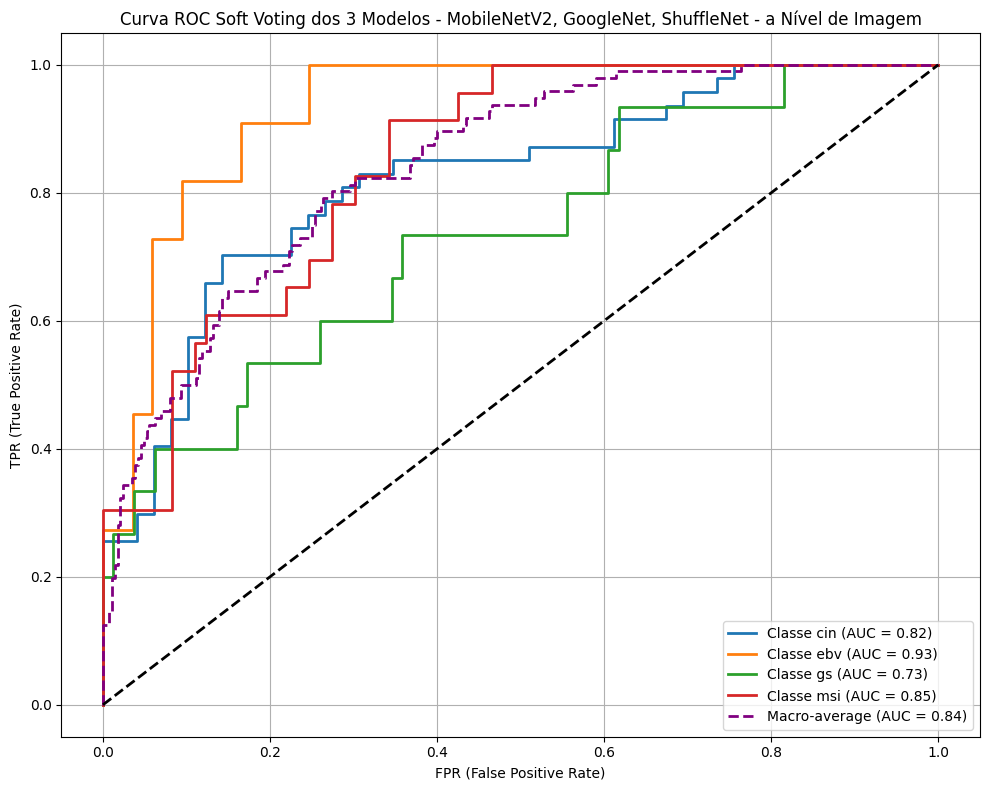

In [33]:
fig_name = 'Curva ROC Soft Voting dos 3 Modelos - MobileNetV2, GoogleNet, ShuffleNet - a Nível de Imagem'
file_name = 'roc_soft_30fold_Image.png'
plot_sodt_roc_curve(agg_image_df, "Image", fig_name, file_name, classes)

In [29]:
agg_patient_df = aggregate_to_level(df, classes, 'patient')
print(f"Quantidade de pacientes: {len(agg_patient_df['patient_id'].value_counts())}")

evaluate_ensembles(agg_patient_df, 'PATIENT')

Quantidade de pacientes: 82
===== Hard Voting 30 folds nível de PATIENT - MobileNet, Google e Shuffle =====
              precision    recall  f1-score   support

         cin       0.57      0.95      0.72        41
         ebv       1.00      0.30      0.46        10
          gs       0.62      0.38      0.48        13
         msi       1.00      0.17      0.29        18

    accuracy                           0.61        82
   macro avg       0.80      0.45      0.48        82
weighted avg       0.73      0.61      0.55        82


===== Soft Voting 30 folds nível de PATIENT - MobileNet, Google e Shuffle =====
              precision    recall  f1-score   support

         cin       0.58      0.98      0.73        41
         ebv       1.00      0.30      0.46        10
          gs       0.71      0.38      0.50        13
         msi       1.00      0.17      0.29        18

    accuracy                           0.62        82
   macro avg       0.82      0.46      0.49       

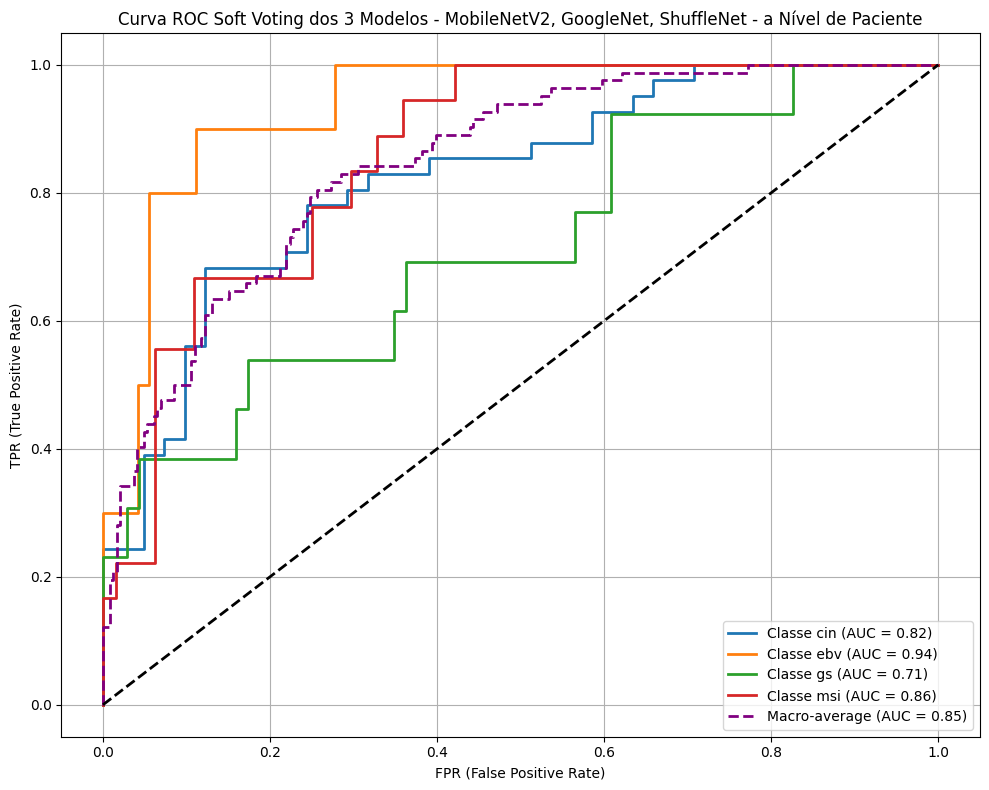

In [35]:
fig_name = 'Curva ROC Soft Voting dos 3 Modelos - MobileNetV2, GoogleNet, ShuffleNet - a Nível de Paciente'
file_name = 'roc_soft_30fold_Patient.png'
plot_sodt_roc_curve(agg_patient_df, "Paciente", fig_name, file_name, classes)